In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Congratulations!
You built a model. Now you have to present it. 

### How might different audiences respond to the following statments:
    
1. The predictive model I built has an accuracy of 80%.
2. The logistic regression was optimized with L2 regularization, so you know it's good.
3. Gender was more important than age in the predictive model because it had a larger coefficient.
4. Here's the AUC chart that shows how well the model did.

### We'll go over how to make 3 charts for classification:

- Probability Plot
- Confusion Matrix
- ROC Curve


## But first let's review our terms:
![](assets/images/confusion_matrix.png)

## ... and talk about geese

# Example walkthrough
Using a dataset of flight delays let's:
- try to predict whether a flight will be delayed by 15 minutes
- visualize our predictions

In [3]:
df = pd.read_csv('assets/dataset/flight_delays.csv')
df.head(3)

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,CRS_DEP_TIME,DEP_TIME,DEP_DEL15,Unnamed: 15
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,900,855,0,NaN
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,1247802,31703,900,856,0,NaN
2,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,1289203,32575,1230,1226,0,NaN


Turn the days of the week into dummy variables and remove null y-values:

In [4]:
df = df.join(pd.get_dummies(df['DAY_OF_WEEK'], prefix='dow'))
df = df[df.DEP_DEL15.notnull()].copy()
df.head(2)

,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,DEST_AIRPORT_ID,...,DEP_TIME,DEP_DEL15,Unnamed: 15,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
0,1,4,2015-01-01,AA,19805,AA,12478,1247802,31703,12892,...,855,0,NaN,0,0,0,1,0,0,0
1,1,4,2015-01-01,AA,19805,AA,12892,1289203,32575,12478,...,856,0,NaN,0,0,0,1,0,0,0


Run a logistic regression model to predict delays:

In [5]:
import sklearn.linear_model as lm

model = lm.LogisticRegression()
#Only features are time of day and day of the week
features = ['CRS_DEP_TIME', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']

X = df[features]
y = df['DEP_DEL15']
#this is a binary column: was the flight delayed or not?

model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

One effective way to explain your model over particular variables is to plot the predicted variables against the most explanatory variables. For example, with logistic regression, plotting the probability of a class against a variable can help explain the range of effect on the model.

```model.predict_proba``` will give you the probability of an outcome, instead of just the outcome:

In [6]:
## COPY THE LECTURE CODE
df['probability'] = model.predict_proba(df[features]).T[1]

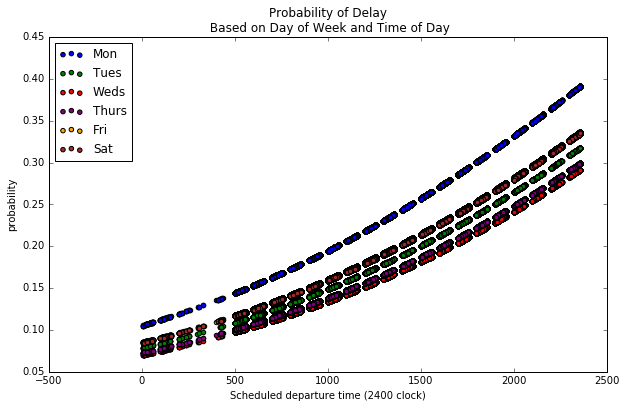

In [7]:
days = ['dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']
names = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat'] 
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

plt.figure(figsize=(10,6))
ax = plt.subplot(111)

for e, c in enumerate(colors):
    df[df[days[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', label = names[e], color = c, ax=ax)

ax.legend(loc='upper left')
ax.set_title('Probability of Delay\n Based on Day of Week and Time of Day')
ax.set_xlabel('Scheduled departure time (2400 clock)')

![Plotting Probabilities](assets/images/plotting_proba.png)


### Advantages of a probability plot
- Interpretable! Shows how odds change with respect to one variable
- Can be helpful to demonstrate key takeaways to a stakeholder

### SKlearn has a built in confusion matrix function that lets you see your cm as a 2x2 matrix

In [10]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X)
cm = confusion_matrix(y,predictions)
cm
##this array is empty: everything is zero, because we never predicted a delay

array([[367333,      0],
       [ 90978,      0]])

Ask yourself: what does this model mean?

In [11]:
sum(predictions)
#although there was a high probability of a delay, no individual time was a predicted delay

0.0

In [11]:
features = ['CRS_DEP_TIME', 'DAY_OF_WEEK', "DAY_OF_MONTH" ]

X = df[features]
y = df['DEP_DEL15']
#this is a binary column: was the flight delayed or not?

model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
predictions = model.predict(X)
sum(predictions)

1255.0

In [13]:
cm = confusion_matrix(y, predictions)
cm

array([[366501,    832],
       [ 90555,    423]])

In [14]:
import matplotlib.patheffects as path_effects

def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline

### We can write some matplotlib to make that confusion matrix look nice

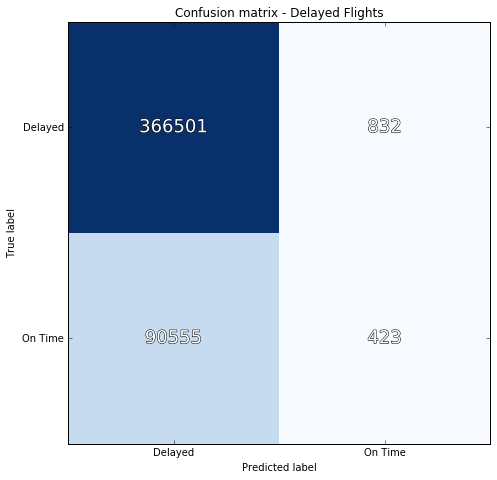

In [15]:
plot_confusion_matrix(cm, title='Confusion matrix - Delayed Flights', labels=['Delayed','On Time'], cmap=plt.cm.Blues)

#note the cmap arguement to use color on this 

Ask yourself: What does good coloring on an confusion matrix look like?

### Advantages of a confusion matrix
- Clearly visualizes what the true and false positive rates are
- Can be useful for a non-techincal audience, but requires good labeling and explanation. 

### Sklearn also has an ROC package that exports your false positive rate, true positive rate and thresholds as 3 arrays

In [16]:
from sklearn.metrics import roc_curve

roc = roc_curve(y, predictions)
roc


(array([ 0.        ,  0.00226497,  1.        ]),
 array([ 0.        ,  0.00464948,  1.        ]),
 array([ 2.,  1.,  0.]))

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    


### We can plot these in matplotlib too:

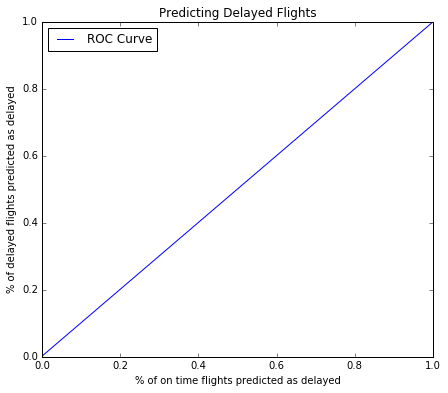

In [18]:
getROCcurve(roc, title='Predicting Delayed Flights', ylabel='% of delayed flights predicted as delayed',\
            xlabel='% of on time flights predicted as delayed')

![](http://gim.unmc.edu/dxtests/roccomp.jpg)

### Advantages of an ROC Curve
- Shows the details of your model's performance as you tune it
- Helpful for stats- and techincal audiences
- Not ideal for non-technical stakeholders

# Guided Practice
Here's a dataset of grad school admissions, based on GPA, rank, and GRE score. In the admit column "1" is admit.

In [25]:
df = pd.read_csv('assets/dataset/collegeadmissions.csv')
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [27]:
## Build a classification model of your choice. 

features = ['gre', 'gpa', 'rank']
X_grad = df[features]
y_grad = df['admit']
model_lm = lm.LogisticRegression()
admit = model_lm.fit(X_grad, y_grad)




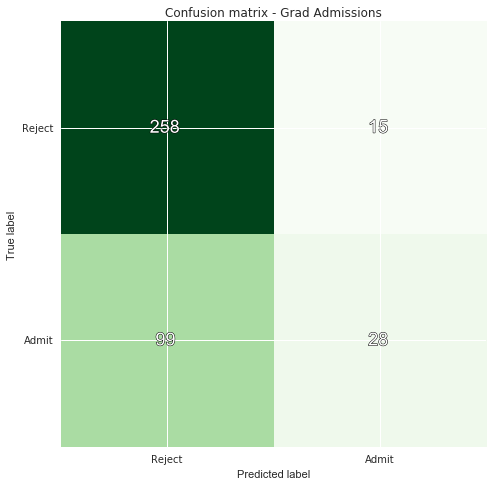

In [66]:
## use your model to predict admissions. 
predictions_grad = admit.predict(X_grad)
prob_grad = model_lm.predict_proba(df[features]).T[1]
cm_grad = confusion_matrix(y_grad, predictions_grad)

plot_confusion_matrix(cm_grad, title='Confusion matrix - Grad Admissions', labels=['Reject','Admit'], cmap=plt.cm.Greens)


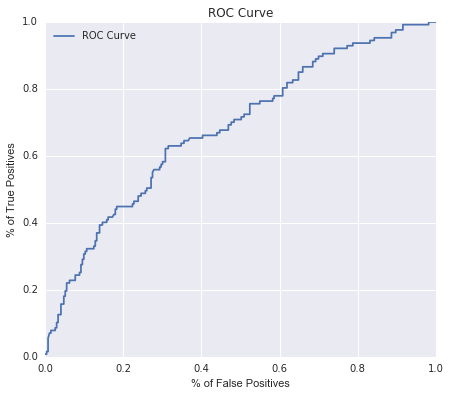

In [59]:
roc_grad = roc_curve(y_grad, prob_grad) #note: this is actual ys and predicted probability of Y
grad_roc_curve = getROCcurve(roc_grad,  title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives')

#note the cmap arguement to use color on this 

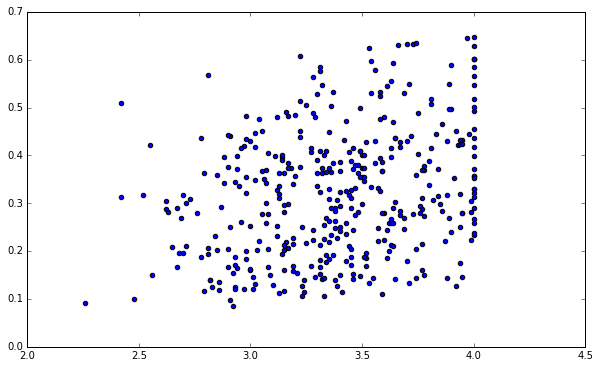

In [46]:


plt.figure(figsize=(10,6))
plt.scatter(x=X_grad['gpa'], y=prob_grad)

# plt.legend(loc='upper left')
# plt.set_title('Probability of Delay\n Based on Day of Week and Time of Day')
# plt.set_xlabel('Scheduled departure time (2400 clock)')


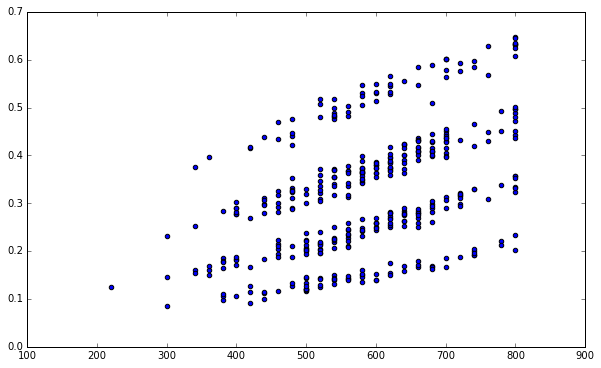

In [49]:


plt.figure(figsize=(10,6))
plt.scatter(x=X_grad['gre'], y=prob_grad)


How well does your prediction do compared to the actual values? 

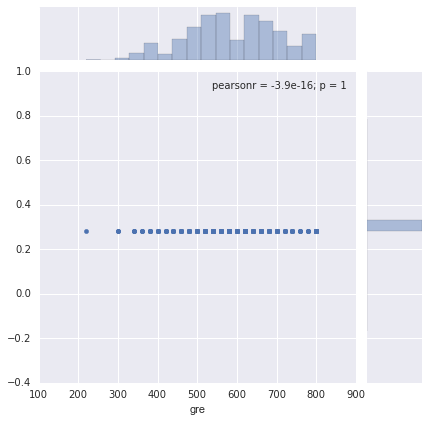

In [57]:
import seaborn as sns



sns.jointplot(this_list, prob_grad, kind='scatter')

# plt.figure(figsize=(10,6))
# plt.scatter(x=X_grad['gre'], y=prob_grad, hue=X_grad['gpa'])


In [56]:
print(prob_grad)

[ 0.18581375  0.28331856  0.64744653  0.15870739  0.12415468  0.42995853
  0.48221936  0.27795824  0.22826391  0.45033105  0.23374381  0.43794216
  0.62976104  0.40617598  0.60258046  0.21042568  0.22208782  0.14914224
  0.48893922  0.51720353  0.20717372  0.41622781  0.1389535   0.16921018
  0.44847671  0.63059943  0.54467008  0.14434721  0.45104853  0.47971236
  0.1502389   0.30891382  0.2495472   0.35688363  0.39651937  0.27666657
  0.5062933   0.20395904  0.32032796  0.19639252  0.31220381  0.36397289
  0.36438939  0.2121575   0.39894241  0.20447865  0.37096374  0.12095805
  0.09942569  0.18317529  0.28382606  0.11264758  0.19191706  0.40677864
  0.26914677  0.33095275  0.22744643  0.16501391  0.30318962  0.1389535
  0.37481924  0.14267685  0.27560252  0.29920892  0.2668923   0.38655067
  0.20038464  0.52810994  0.52989004  0.63409565  0.28997936  0.08491695
  0.12658705  0.39841528  0.1886608   0.32252323  0.23392773  0.35688363
  0.48016132  0.56535998  0.16586556  0.36929813  0.

### Confusion Matrix

In [ ]:
## Generate a confusion matrix in sklearn


In [ ]:
## plot the confusion matrix in matplotlib. 
## BONUS: customize it. Play with the colors, labels and axes


### ROC Curve

In [ ]:
## Generate an ROC Curve in sklearn

In [ ]:
## plot the confusion matrix in matplotlib. 
## BONUS: customize it. Play with the colors and labels

# BONUS: Evaluate Your Model
Look up the following sklearn metrics, explain what they mean, and use them to explain how well your model is doing.

You can read more here: http://scikit-learn.org/stable/modules/classes.html#classification-metrics



In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc #area under the curve -- which curve?

In [61]:
print(grad_roc_curve.auc)

NameError: name 'grad_roc_curve' is not defined

In [73]:
auc(prob_grad, y_grad, reorder=1)

0.21061217463938209

In [70]:
recall_score(y_grad, predictions_grad)

0.22047244094488189

In [71]:
accuracy_score(y_grad, predictions_grad)

0.71499999999999997

In [72]:
precision_score(y_grad, predictions_grad)

0.65116279069767447